In [51]:
imagePath = "T_Sheep_BaseColor.tga"

In [71]:
from perlin_numpy import generate_fractal_noise_2d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = Image.open(imagePath)

In [72]:
def color(h,s,v):
    return np.array([h * (255 / 360), s * (255 / 100), v * (255 / 100)], dtype="uint8")

baseColor = color(30, 80, 40)

In [199]:
coats = [["White", 100, color(30,  10, 70)],
         ["Gray",  100, color(240, 10, 30)],
         ["Black", 100, color(30,  10, 10)],
         ["Brown", 100, color(30,  80, 40)]]

for name, num, baseColor in coats:

    alpha = np.asarray(image)[:,:,3]
    hsv = np.asarray(image.convert("HSV"), dtype="int32")

    hue = hsv[:,:,0]
    saturation = hsv[:,:,1]
    value = hsv[:,:,2]

    furCondition = np.logical_and.reduce([alpha > 0, saturation < 128, value > 96])

    meanHue = hue.mean(where=furCondition)
    meanSaturation = saturation.mean(where=furCondition)
    meanValue = value.mean(where=furCondition)

    valueMask = 1 - np.abs(value - meanValue) / meanValue

    inputColor = np.array([meanHue, meanSaturation, meanValue])

    hueShift = int(baseColor[0] - inputColor[0])
    saturationShift = np.array(valueMask * (baseColor[1] - inputColor[1]), dtype="int32")
    valueShift = int(baseColor[2] - inputColor[2])

    hsv[:,:,0] += hueShift
    hsv[:,:,1] += saturationShift
    hsv[:,:,2] += valueShift

    #saturationNoise = np.array(30 * ((1 + generate_fractal_noise_2d((4096, 4096), (4,4), 8)) / 2 - baseColor[1] / 255), dtype="int32")
    #valueNoise = np.array(70 * ((1 + generate_fractal_noise_2d((4096, 4096), (4,4), 8)) / 2 - baseColor[2] / 255), dtype="int32")
    saturationNoise = np.array(np.log(1 + baseColor[1] / 255) * 255 * fractalNoise(baseColor[1] / 255), dtype="int32")
    valueNoise = np.array(np.log(1 + baseColor[2] / 255) * 255 * fractalNoise(baseColor[2] / 255), dtype="int32")

    print(name, "saturation", 100 * saturationNoise.min() / 255, 100 * saturationNoise.max() / 255, "value", 100 * valueNoise.min() / 255, 100 * valueNoise.max() / 255)

    hsv[:,:,1] += saturationNoise
    hsv[:,:,2] += valueNoise

    hsv = np.array(hsv.clip(0,255), dtype="uint8")

    red = np.array([0,255,255])

    output = Image.fromarray(hsv, "HSV").convert("RGB")
    a = Image.fromarray(alpha, "L")
    #output.putalpha(a)

    output.save(f"{name}.png")

White saturation -0.7843137254901961 10.588235294117647 value -40.78431372549019 18.823529411764707
Gray saturation -0.7843137254901961 9.019607843137255 value -8.627450980392156 22.745098039215687
Black saturation -0.7843137254901961 9.019607843137255 value -0.7843137254901961 9.803921568627452
Brown saturation -49.80392156862745 15.294117647058824 value -14.509803921568627 23.92156862745098


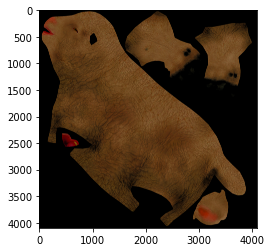

In [20]:
plt.imshow(output)

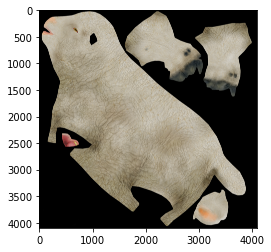

In [174]:
plt.imshow(image.convert("RGB"))

-0.67105202147438 0.2692704341917526


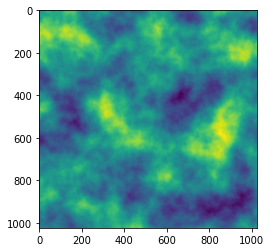

In [191]:
noise = generate_fractal_noise_2d((1024, 1024), (4,4), 8) / 2 - 40/2/100
print(noise.min(), noise.max())
plt.imshow(noise)

-0.11885994073012673 -0.0005050353381295392 1.0520494193292749


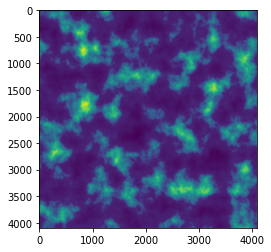

In [196]:
# Adjust brightness and contrast of noise

def fractalNoise(shift: float):
    noise = generate_fractal_noise_2d((4096, 4096), (8,8), 8)

    #adjustedNosie = np.abs(noise) - 1 + (1 - np.abs(noise)) * (shift + 1)
    adjustedNosie = np.where(noise < 0, - noise - 1 + (1 + noise) * (shift + 1), noise + (1 - noise) * shift)

    return adjustedNosie - shift

value = 0.1

result = fractalNoise(value)
print(result.min(), np.median(result), result.max())
#plt.hist(result.flat, 100)
plt.imshow(result)
plt.show()